In [1]:
import numpy as np
import matplotlib.pyplot as plt
import config.constants as cc
import grid
import grid.io.netcdf as nc
import grid.multiscale as ms
import datetime
import cartopy
from pynextsim.irregular_grid_interpolator import IrregularGridInterpolator

def filename(varname, t):
    return "/Users/yueng/mnt/nersc/sim/data/ERA5/ERA5_{}_y{:04d}.nc".format(varname, t.year)

In [2]:
t0 = datetime.datetime.strptime('200701010000', '%Y%m%d%H%M')
dt = datetime.timedelta(hours=1*cc.CYCLE_PERIOD)
dt_in_file = datetime.timedelta(hours=1)

f = nc.Dataset(filename('u10', t0))
lon, lat = np.meshgrid(f['longitude'][:], f['latitude'][:])
tmp = grid.crs.transform_points(cartopy.crs.PlateCarree(), lon, lat)
x = tmp[:,:,0]
y = tmp[:,:,1]
igi = IrregularGridInterpolator(x, y, grid.x_ref, grid.y_ref)

In [17]:
t = datetime.datetime.strptime('200702040600', '%Y%m%d%H%M')
t_index = int((t-datetime.datetime(t.year,1,1,0,0,0))/dt_in_file)
u = nc.Dataset(filename('u10', t))['u10'][t_index, :, :]
v = nc.Dataset(filename('v10', t))['v10'][t_index, :, :]
u, v = grid.rotate_vector(x, y, u, v)
u_ref = igi.interp_field(u)
v_ref = igi.interp_field(v)

In [18]:
def pert_file(s,n):
    return "/Users/yueng/mnt/betzy/scratch/test/run/perturbation/scale{}/synforc_{:04d}.nc".format(s,n)

u_out = u_ref.copy(); v_out = v_ref.copy()
n = 1

for s in range(4):
    u_out += nc.Dataset(pert_file(s, n))['uwind'][0, 0, :, :].T
    v_out += nc.Dataset(pert_file(s, n))['vwind'][0, 0, :, :].T

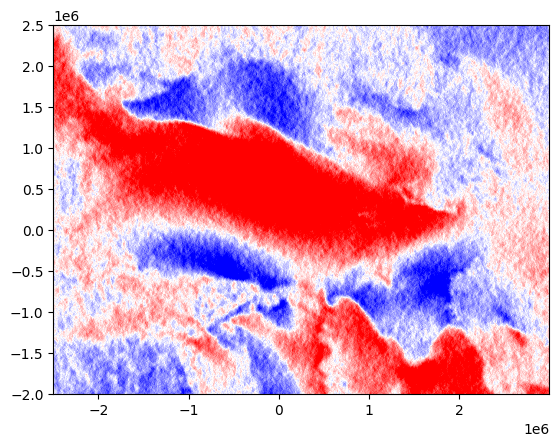

In [19]:
plt.pcolor(grid.x_ref, grid.y_ref, u_out, vmin=-10, vmax=10, cmap='bwr')

Text(0.5, 0, 'wavelength (km)')

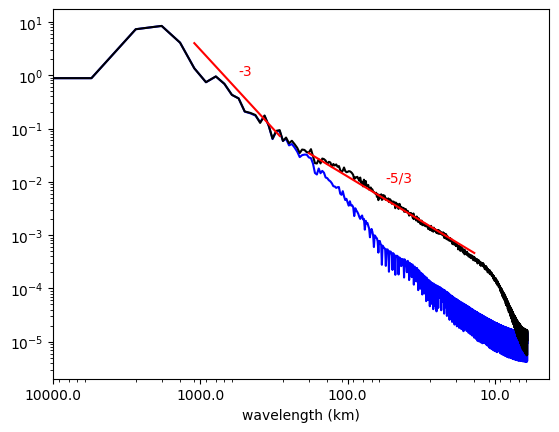

In [22]:
fig, ax = plt.subplots(1, 1)

L=5500.

wn, pwr_u = ms.pwrspec2d(u_ref)
wn, pwr_v = ms.pwrspec2d(v_ref)
ax.loglog(wn, 0.5*(pwr_u+pwr_v), 'b')

wn, pwr_u = ms.pwrspec2d(u_out)
wn, pwr_v = ms.pwrspec2d(v_out)
ax.loglog(wn, 0.5*(pwr_u+pwr_v), 'k')

##ref lines
wn1 = np.arange(5., 20.)
ax.loglog(wn1, 5e2*wn1**-3, 'r')
ax.text(10, 1, '-3', color='r')
wn2 = np.arange(30., 400.)
ax.loglog(wn2, 1e1*wn2**(-5/3), 'r')
ax.text(100, 1e-2, '-5/3', color='r')

wl = np.array([1e4, 1e3, 1e2, 1e1])
ax.set_xticks(L/wl)
ax.set_xticklabels(wl)
ax.set_xlabel('wavelength (km)')